# Testing for momentum budget fractional thickness multiplied diagnostics

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import xarray as xr
from xgcm import Grid
import dask 
import dask.distributed
%matplotlib inline

In [20]:
ppdir = "/work/Hemant.Khatri/MOM6_idealised/MOM_budget/Layer_SWM/2L/"

ds_mom = xr.open_dataset(ppdir + "TW_diag_test/mom_avg.nc")
ds_prog = xr.open_dataset(ppdir + "TW_diag_test/prog_avg.nc")
dsgrid = xr.open_dataset(ppdir + "ocean_month.nc")

ds = xr.merge([ds_mom, ds_prog, dsgrid])

/home/Hemant.Khatri/anaconda3/envs/analysis_python3/lib/python3.7/site-packages/xarray/coding/times.py:465: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/Hemant.Khatri/anaconda3/envs/analysis_python3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


In [21]:
ds

<xarray.Dataset>
Dimensions:      (Time: 6, nv: 2, xh: 400, xq: 400, yh: 200, yq: 200, zl: 2)
Coordinates:
  * Time         (Time) object 0011-01-04 00:00:00 ... 0021-04-06 00:00:00
  * xq           (xq) float64 4.0 8.0 12.0 16.0 ... 1.592e+03 1.596e+03 1.6e+03
  * yh           (yh) float64 2.0 6.0 10.0 14.0 18.0 ... 786.0 790.0 794.0 798.0
  * zl           (zl) float64 1.027e+03 1.028e+03
  * nv           (nv) float64 1.0 2.0
  * xh           (xh) float64 2.0 6.0 10.0 14.0 ... 1.59e+03 1.594e+03 1.598e+03
  * yq           (yq) float64 4.0 8.0 12.0 16.0 20.0 ... 788.0 792.0 796.0 800.0
Data variables:
    dudt         (Time, zl, yh, xq) float32 1.4723479e-08 1.4258654e-08 ... nan
    dvdt         (Time, zl, yq, xh) float32 5.012975e-10 4.8238963e-10 ... nan
    CAu          (Time, zl, yh, xq) float32 3.551682e-08 3.037102e-08 ... nan
    CAv          (Time, zl, yq, xh) float32 -2.789586e-07 -2.1196522e-07 ... nan
    PFu          (Time, zl, yh, xq) float32 -2.8134727e-08 ... nan
    PF

In [23]:
grid = Grid(ds, coords={'X': {'center': 'xh', 'right': 'xq'},
                        'Y': {'center': 'yh', 'right': 'yq'} }, periodic=['X'])

In [24]:
H = ds['h'].sum('zl') 
h_frac = ds['h'] / H

h_fracu = grid.interp(h_frac,'X')
h_fracv = grid.interp(h_frac,'Y',boundary='fill')

Text(0, 0.5, 'y (km)')

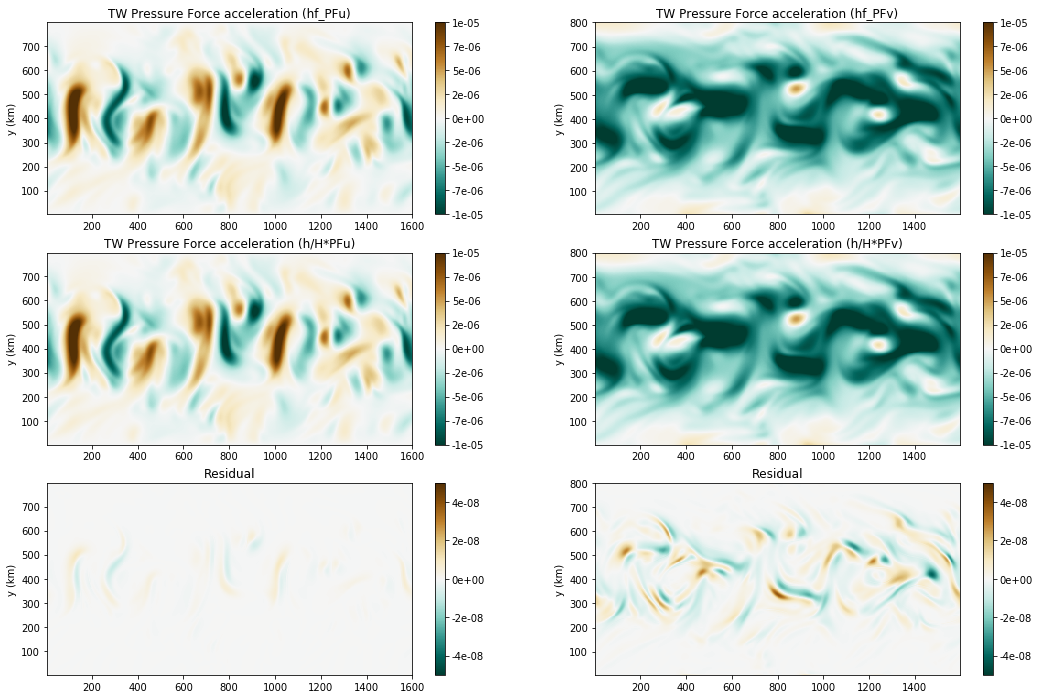

In [19]:
# Compare (h/H)Pfu and hf_Pfu (Snapshots)

tmp_PFu = h_fracu*ds['PFu']
tmp_PFv = h_fracv*ds['PFv']

idx = 2; i = 0
plt.figure(figsize=(18,12))
max_r = [1.e-5, 1.e-5]

plt.subplot(3,2,1)
plt.pcolor(ds['xq'], ds['yh'], ds['hf_PFu'].isel(Time=idx, zl=i), vmin = -max_r[i], vmax = max_r[i], cmap='BrBG_r')
plt.title('TW Pressure Force acceleration (hf_PFu)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(3,2,2)
plt.pcolor(ds['xh'], ds['yq'], ds['hf_PFv'].isel(Time=idx, zl=i), vmin = -max_r[i], vmax = max_r[i], cmap='BrBG_r')
plt.title('TW Pressure Force acceleration (hf_PFv)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(3,2,3)
plt.pcolor(ds['xq'], ds['yh'], tmp_PFu.isel(Time=idx, zl=i), vmin = -max_r[i], vmax = max_r[i], cmap='BrBG_r')
plt.title('TW Pressure Force acceleration (h/H*PFu)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(3,2,4)
plt.pcolor(ds['xh'], ds['yq'], tmp_PFv.isel(Time=idx, zl=i), vmin = -max_r[i], vmax = max_r[i], cmap='BrBG_r')
plt.title('TW Pressure Force acceleration (h/H*PFv)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(3,2,5)
plt.pcolor(ds['xq'], ds['yh'], (ds['hf_PFu']-tmp_PFu).isel(Time=idx, zl=i), vmin = -0.5e-2*max_r[i], vmax = 0.5e-2*max_r[i], cmap='BrBG_r')
plt.title('Residual')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(3,2,6)
plt.pcolor(ds['xh'], ds['yq'], (ds['hf_PFv']-tmp_PFv).isel(Time=idx, zl=i), vmin = -0.5e-2*max_r[i], vmax = 0.5e-2*max_r[i], cmap='BrBG_r')
plt.title('Residual')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

Text(0, 0.5, 'y (km)')

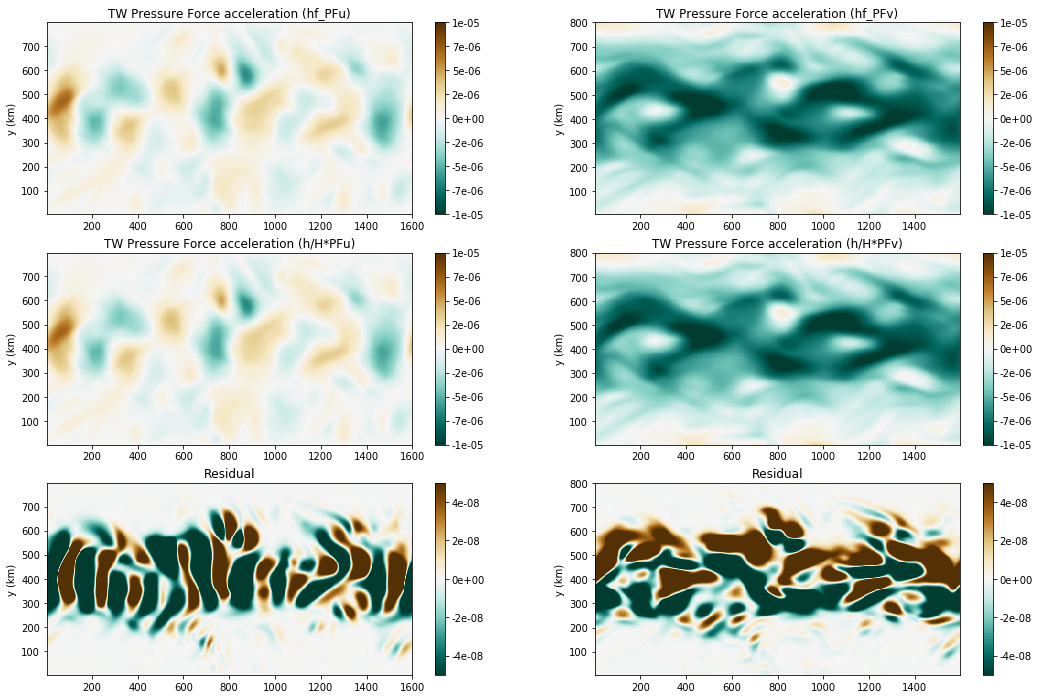

In [25]:
# Compare (h/H)Pfu and hf_Pfu (10-day averaged fields)

tmp_PFu = h_fracu*ds['PFu']
tmp_PFv = h_fracv*ds['PFv']

idx = 2; i = 0
plt.figure(figsize=(18,12))
max_r = [1.e-5, 1.e-5]

plt.subplot(3,2,1)
plt.pcolor(ds['xq'], ds['yh'], ds['hf_PFu'].isel(Time=idx, zl=i), vmin = -max_r[i], vmax = max_r[i], cmap='BrBG_r')
plt.title('TW Pressure Force acceleration (hf_PFu)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(3,2,2)
plt.pcolor(ds['xh'], ds['yq'], ds['hf_PFv'].isel(Time=idx, zl=i), vmin = -max_r[i], vmax = max_r[i], cmap='BrBG_r')
plt.title('TW Pressure Force acceleration (hf_PFv)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(3,2,3)
plt.pcolor(ds['xq'], ds['yh'], tmp_PFu.isel(Time=idx, zl=i), vmin = -max_r[i], vmax = max_r[i], cmap='BrBG_r')
plt.title('TW Pressure Force acceleration (h/H*PFu)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(3,2,4)
plt.pcolor(ds['xh'], ds['yq'], tmp_PFv.isel(Time=idx, zl=i), vmin = -max_r[i], vmax = max_r[i], cmap='BrBG_r')
plt.title('TW Pressure Force acceleration (h/H*PFv)')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(3,2,5)
plt.pcolor(ds['xq'], ds['yh'], (ds['hf_PFu']-tmp_PFu).isel(Time=idx, zl=i), vmin = -0.5e-2*max_r[i], vmax = 0.5e-2*max_r[i], cmap='BrBG_r')
plt.title('Residual')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')

plt.subplot(3,2,6)
plt.pcolor(ds['xh'], ds['yq'], (ds['hf_PFv']-tmp_PFv).isel(Time=idx, zl=i), vmin = -0.5e-2*max_r[i], vmax = 0.5e-2*max_r[i], cmap='BrBG_r')
plt.title('Residual')
plt.colorbar(format='%.0e')
plt.ylabel('y (km)')